# MNIST

## Data Acquisition

In [1]:
from sklearn.datasets import fetch_openml

In [2]:
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:
X, y = mnist['data'], mnist['target']

In [4]:
X.shape

(70000, 784)

In [5]:
y.shape

(70000,)

### Viewing a digit

In [20]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

In [16]:
plt.style.use('dark_background')

In [17]:
some_digit = X.iloc[0]
some_digit_image = some_digit.values.reshape(28, 28)

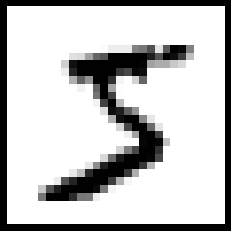

In [18]:
plt.imshow(some_digit_image, cmap= mpl.cm.binary, interpolation='nearest')
plt.axis('off')
plt.show()

In [19]:
# check the label 
y.iloc[0]

'5'

In [21]:
# the labels are originally strings. Need to cast y to integers
y = y.astype(np.uint8)

### Creating Train and Test Sets

In [25]:
X_train, X_test, y_train, y_test = X[:60_000], X[60_000:], y[:60_000], y[60_000:]

#### Training a Binary Classifier (5 or not 5)

In [27]:
# create the target vectors
y_train_5 = (y_train == 5) # true for all 5s. False for all other digits
y_test_5 = (y_test == 5)

In [28]:
from sklearn.linear_model import SGDClassifier

In [29]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [30]:
sgd_clf.predict([some_digit])

array([ True])

## Performance Measures

### Implement Cross-Validation

In [31]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone


In [33]:
skfolds = StratifiedKFold(n_splits=3)

In [35]:
for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train.iloc[train_index]
    y_train_folds = y_train_5.iloc[train_index]
    X_test_fold = X_train.iloc[test_index]
    y_test_fold = y_train_5.iloc[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))    

0.95035
0.96035
0.9604


In [36]:
from sklearn.model_selection import cross_val_score

In [37]:
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

Accuracy is not generally preferred performance measure for classifiers specially when dealing with skewed datasets. In this case, each digit has around 10% of the population and using a binary classifier, it will always have at least 90% of accuracy

### Confusion Matrix

In [38]:
from sklearn.model_selection import cross_val_predict

In [39]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [42]:
from sklearn.metrics import confusion_matrix

In [43]:
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

### Precision and Recall

In [44]:
from sklearn.metrics import precision_score, recall_score

In [45]:
precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [46]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

In [47]:
# f1 score
from sklearn.metrics import f1_score

In [48]:
f1_score(y_train_5, y_train_pred)

0.7325171197343846

#### Precision/Recall trade-off

In [49]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [52]:
threshold = 0
y_some_digit_pred = (y_scores > threshold) # returns True as predict() method
y_some_digit_pred

array([ True])

In [54]:
# increasing the threshold
threshold = 8000
y_some_digit_pred = (y_scores > threshold) # returns false
y_some_digit_pred

array([False])

In [55]:
# get the decision scores for X_train to decide on threshold
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')

In [59]:
# compute precision and recall for all possible thresholds using the precision_recall_curve()
from sklearn.metrics import precision_recall_curve

In [134]:
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [135]:
precisions

array([0.09040123, 0.09038606, 0.09038757, ..., 1.        , 1.        ,
       1.        ])

In [136]:
recalls

array([1.00000000e+00, 9.99815532e-01, 9.99815532e-01, ...,
       3.68935621e-04, 1.84467810e-04, 0.00000000e+00])

In [137]:
thresholds

array([-106527.45300471, -105763.22240074, -105406.2965229 , ...,
         38871.26391927,   42216.05562787,   49441.43765905])

In [143]:
# print precision and recall  as functions of the threshold
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.figure(figsize=(12,9))
    plt.plot(thresholds, precisions[:-1], '--', label='Precision', color='orange')
    plt.plot(thresholds, recalls[:-1], '-', label='Recall', color='magenta')
    plt.legend()
    plt.grid(b=True)
    plt.xlabel('THRESHOLD')

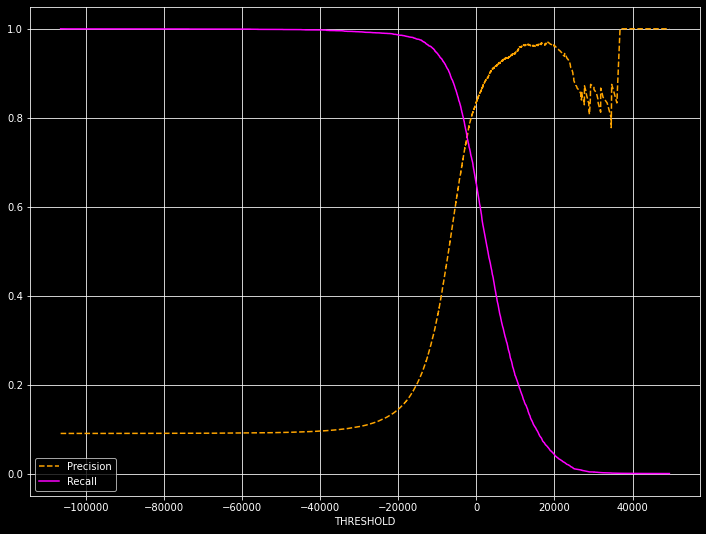

In [144]:
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)


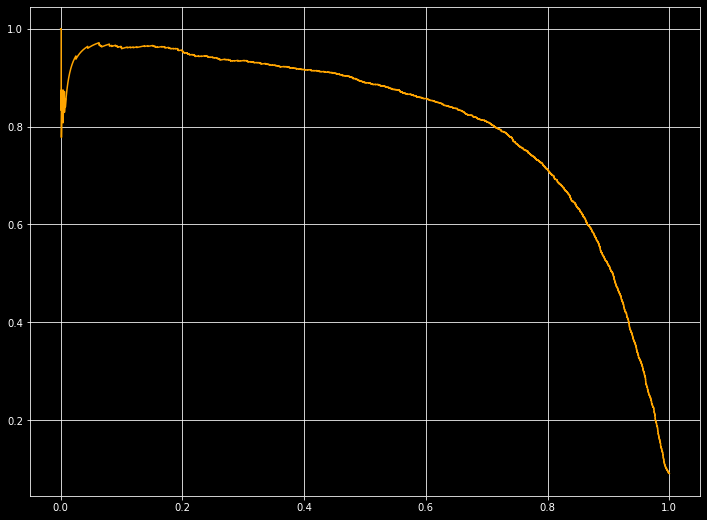

In [148]:
# plot precision against recall
plt.figure(figsize=(12,9))
plt.plot(recalls, precisions, color='orange')
plt.grid(b=True)


In [149]:
# decide to have 90% precision
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
threshold_90_precision

3370.0194991439557

In [150]:
# make predictions on the training set using the threshold precision
y_train_pred_90 = (y_scores >= threshold_90_precision)
y_train_pred_90

array([False, False, False, ...,  True, False, False])

In [151]:
p_score = precision_score(y_train_5, y_train_pred_90)
p_score

0.9000345901072293

In [152]:
r_score = recall_score(y_train_5, y_train_pred_90)
r_score

0.4799852425751706

### ROC Curve

In [173]:
from sklearn.metrics import roc_curve

In [174]:
pfr, tpr, thresholds = roc_curve(y_train_5, y_scores)

In [177]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.figure(figsize=(12,9))
    plt.plot(fpr, tpr, linewidth=2, label=label, color='orange')
    plt.plot([0, 1], [0,1], 'k--')
    plt.xlabel('FPR - False Positive Rate')
    plt.ylabel('TPR - True Positive Rate')
    plt.grid(True)

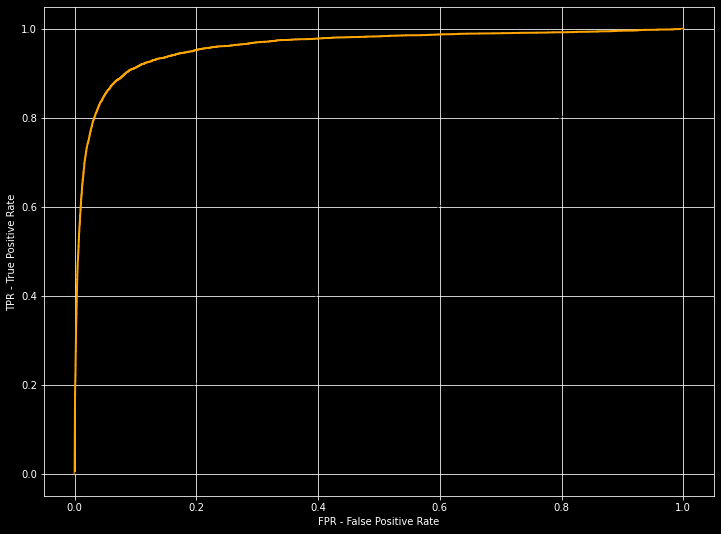

In [178]:
plot_roc_curve(fpr, tpr)

In [197]:
from sklearn.metrics import roc_auc_score

In [198]:
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

### Using a Random Forerst Classifier

In [179]:
from sklearn.ensemble import RandomForestClassifier

In [180]:
forest_clf = RandomForestClassifier(random_state=42)

In [181]:
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method='predict_proba')

In [182]:
y_scores_forest = y_probas_forest[:, 1] # probability of the positive class (5s)

In [183]:
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

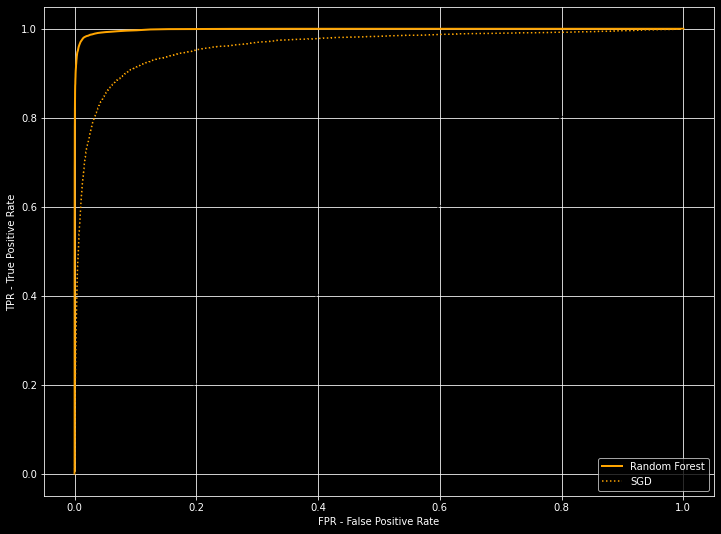

In [195]:
#plot the ROC Curve
plot_roc_curve(fpr_forest, tpr_forest, 'Random Forest')
plt.plot(fpr, tpr, 'b:', label='SGD', color='orange')
plt.legend(loc='lower right')

RandomForestClassifier's ROC curve looks much better than the SGD. (closer to the top left)

In [199]:
# calculate the ROC AUC
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145